## Project: Finding Donors for *CharityML*

# Finding Potential Donors for CharityML: A Machine Learning Approach

In this notebook, I'll build a machine learning model to identify potential donors for CharityML based on census data. I've structured this project to showcase my ability to implement a complete machine learning pipeline from data exploration to model selection and evaluation.

Throughout this notebook, I'll document my process, explain key decisions, and analyze results as I work through various techniques in supervised learning. The implementation will demonstrate my skills in data preprocessing, algorithm selection, hyperparameter tuning, and model evaluation.

I'm using Python 3.12 for this project, along with libraries such as NumPy, Pandas, Matplotlib, and Scikit-learn for data manipulation, visualization, and machine learning tasks.

# Project Goal: Predicting Potential Donors

In this project, I'll employ supervised learning algorithms to model individuals' income based on data collected from the 1994 U.S. Census. After comparing several algorithms, I'll select the most promising one and optimize it further to accurately predict whether an individual makes more than $50,000 annually.

This task has practical applications for non-profit organizations like CharityML that rely on donations. By understanding an individual's likely income bracket, I can help the organization determine whether to reach out to specific individuals and what donation amount might be appropriate to request. While direct income information isn't always publicly available, I can infer this information from other available features.

The dataset I'm using comes from the UCI Machine Learning Repository, originally published in Ron Kohavi and Barry Becker's article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid." I'm working with a slightly modified version of the original dataset, with the `fnlwgt` feature removed and records with missing or ill-formatted entries excluded.

## Exploring the Data
Now I'll load the necessary Python libraries and the census data. The `income` column will be my target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks

%matplotlib inline


# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=10))

ModuleNotFoundError: No module named 'pandas'

### Conducting Data Exploration

In this first step, I'll perform a basic investigation of the dataset to understand the distribution of income levels. I need to determine:

- The total number of records in the dataset
- How many individuals earn more than $50,000 annually
- How many individuals earn at most $50,000 annually
- The percentage of individuals making more than $50,000

This initial exploration will help me understand the class distribution in the data, which is important for evaluating model performance later on.

In [9]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = np.sum([data['income'] == '>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = n_records - n_greater_50k

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 0.2478439697492371%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

## Addressing Skewed Features

A dataset may sometimes contain features whose values tend to cluster near a single number, but also have a non-trivial number of vastly larger or smaller values than that number. My machine learning algorithms can be sensitive to such distributions and might underperform if the range isn't properly normalized.

In the census dataset, two features exhibit this skewed characteristic: `capital-gain` and `capital-loss`. I'll plot histograms of these features to visualize their distributions and better understand the range of values present.

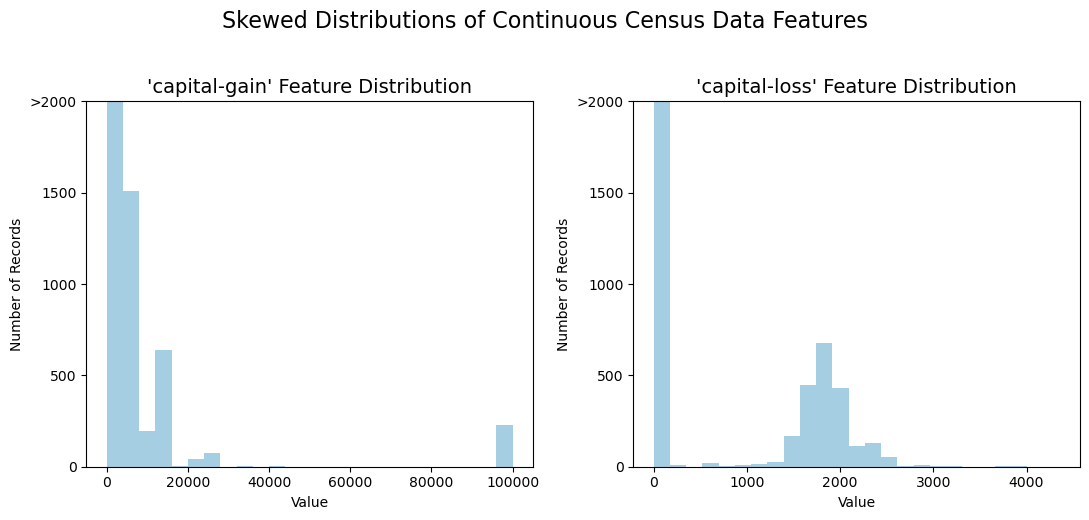

In [13]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

I'll apply a logarithmic transformation to handle the highly-skewed `capital-gain` and `capital-loss` features. This is a standard practice that significantly reduces the range of values caused by outliers, which can help improve algorithm performance.

When applying this transformation, I need to be careful with zero values since log(0) is undefined. To address this, I'll add a small constant to all values before taking the logarithm, effectively translating them slightly above zero.

After applying this transformation, I'll visualize the results to see how the distribution has changed. This should give me a much more even distribution that will be easier for my models to work with.

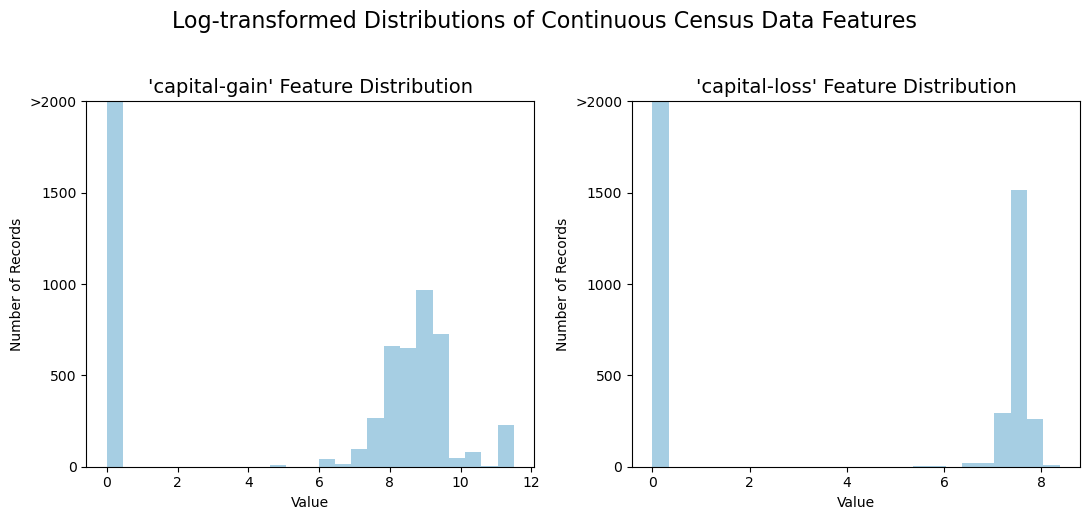

In [15]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

## Normalizing Numerical Features

In addition to transforming skewed features, I'll now normalize all the numerical features in my dataset. Although normalization doesn't change the shape of each feature's distribution, it ensures that each feature is treated equally by my supervised learning algorithms.

For this normalization step, I'll use `sklearn.preprocessing.MinMaxScaler`, which will scale all values to be between 0 and 1. This is important because features with larger ranges might otherwise dominate the learning process and lead to suboptimal model performance.

It's worth noting that once I apply this scaling, the data in its raw form will no longer have the same original meaning. However, this transformation is necessary for many machine learning algorithms to perform effectively.

In [ ]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 10))

ModuleNotFoundError: No module named 'sklearn'

## Handling Categorical Features

Looking at my dataset, I can see several features that are non-numeric (categorical variables). Since machine learning algorithms typically expect numerical input, I need to convert these categorical variables into a numerical format.

I'll use one-hot encoding to handle this transformation, which creates a "dummy" variable for each possible category of each non-numeric feature. For example, if a feature like `education` has values such as "Bachelors," "Masters," and "PhD," one-hot encoding would create three separate binary columns, with a 1 indicating the presence of that category.

For the target variable `income`, which has only two categories ("<=50K" and ">50K"), I can use a simpler binary encoding:
- "<=50K" will be encoded as 0
- ">50K" will be encoded as 1

To implement this:
1. I'll use `pandas.get_dummies()` to perform one-hot encoding on all categorical features
2. I'll convert the target label to numerical values (0 and 1)

This preprocessing step is crucial as it transforms all my data into a format that machine learning algorithms can process effectively.

In [19]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = (income_raw == '>50K').astype(int)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)
income


103 total features after one-hot encoding.


0        0
1        0
2        0
3        0
4        0
        ..
45217    0
45218    0
45219    0
45220    0
45221    1
Name: income, Length: 45222, dtype: int64

## Splitting Data for Training and Validation

Now that I've completed all necessary preprocessing steps—converting categorical variables to numerical features and normalizing all numerical features—I can proceed to split my data into training and testing sets.

I'll use 80% of the data for training my models and reserve 20% for testing their performance. This split is crucial for properly evaluating how well my models will generalize to unseen data.

This separation ensures that I can train my models on one dataset and then test them on completely different data that the model hasn't seen before. This approach helps me avoid overfitting and provides a more realistic assessment of how my final model will perform in real-world situations.

In [21]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


# Evaluating Model Performance

In this section, I'll investigate four different algorithms and determine which one best models the data. Three of these will be supervised learning algorithms I've selected based on their suitability for this classification task, and the fourth will be a naive predictor that will serve as a baseline for comparison.

The naive predictor will help establish a minimum performance threshold that my chosen algorithms should exceed to demonstrate their value. From there, I'll compare the performance of my three selected algorithms to identify which one shows the most promise for further optimization.

# Understanding Performance Metrics for Donor Prediction

In this project, I need to be strategic about the performance metrics I use to evaluate my models. Since CharityML is focused on identifying individuals who make more than $50,000 (as they're most likely to donate), I need to consider what errors would be most problematic.

While accuracy might seem like a natural choice, it can be misleading in this case due to the imbalanced class distribution. Looking at the data, most individuals don't make more than $50,000, so simply predicting everyone as "≤$50K" would give high accuracy but would be useless for CharityML's goals of finding donors.

In this context, precision is particularly important - when my model predicts someone makes more than $50,000, I want to be confident that's correct. False positives would lead CharityML to waste resources pursuing unlikely donors. Recall is still relevant but less critical than precision for this specific business need.

Therefore, I'll use the F-beta score with β=0.5 (F₀.₅ score) which places more emphasis on precision than recall:

F₀.₅ = (1 + 0.5²) × (precision × recall) / ((0.5² × precision) + recall)

This metric will help me identify models that are especially good at precisely identifying potential donors while still maintaining reasonable recall.

For context, I'll briefly review what these metrics mean:
- Precision = True Positives / (True Positives + False Positives)
- Recall = True Positives / (True Positives + False Negatives)

I'll compare all my models against a naive baseline to ensure they're providing meaningful value beyond simple guessing.

In [25]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = TP / (TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5 * 0.5) * (precision * recall) / (0.5 * 0.5 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


# Selecting Supervised Learning Models

For this classification problem, I'll evaluate several supervised learning models from scikit-learn's rich collection. After considering the nature of the data and the specific requirements of this donor prediction task, I've decided to focus on the following algorithms:

1. **Random Forest** - This ensemble method tends to handle both numerical and categorical features well, is robust against overfitting, and can provide feature importance metrics that will help me understand what factors most strongly predict income level.

2. **Decision Tree** - Decision trees are interpretable machine learning models that make predictions by following a hierarchical tree structure of if-then rules. They recursively split data based on feature values, creating paths from root to leaf nodes where predictions are made. While simple to understand and visualize, basic decision trees can overfit.

3. **Logistic Regression** - As a baseline linear model, logistic regression offers good interpretability while often providing competitive performance. It's also computationally efficient, which is beneficial when working with larger datasets.

Each of these algorithms has different strengths that make them appropriate choices for this task. Random Forest can handle non-linear relationships and feature interactions, Decision Trees provide clear interpretability, and Logistic Regression offers a straightforward approach with good explainability.

In the next section, I'll implement and compare these models to determine which one performs best on my specific task of identifying potential donors.

## Building an Efficient Model Evaluation Pipeline

To systematically evaluate each model's performance, I need to create a robust training and prediction pipeline. This will allow me to consistently measure how each algorithm performs across different metrics and training data sizes.

I'll implement a pipeline that:
1. Trains each model on the training data
2. Records training time for efficiency comparison
3. Makes predictions on both test data and a subset of training data
4. Calculates key performance metrics:
   - Accuracy score - to measure overall correctness
   - F-beta score - with beta=0.5 to emphasize precision over recall

By evaluating models on both training and testing data, I can also identify whether any models are prone to overfitting (performing much better on training than testing data).

This standardized approach will ensure fair comparisons between models and help me select the best performer for my donor prediction task.

In [30]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

## Setting Up Model Evaluation

For my supervised learning task, I'll implement and evaluate three machine learning models that are well-suited for classification problems:

1. Random Forest
2. Decision Tree
3. Logistic Regression

I'll initialize these models with their default parameters and a fixed random state to ensure reproducibility. Later, I'll select the best-performing model for further optimization.

To understand how each model performs with different amounts of training data, I'll evaluate them using 1%, 10%, and 100% of the available training data. This will help me assess how efficiently each model learns from limited data and whether it continues to improve with more training examples.

This approach will give me insight into both the performance ceiling of each algorithm and its data efficiency, which is important for understanding real-world applications where training data might be limited.

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


/Users/lixinwei/Documents/GitHub/cd0025-supervised-learning/starter/visuals.py:124: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  pl.tight_layout()


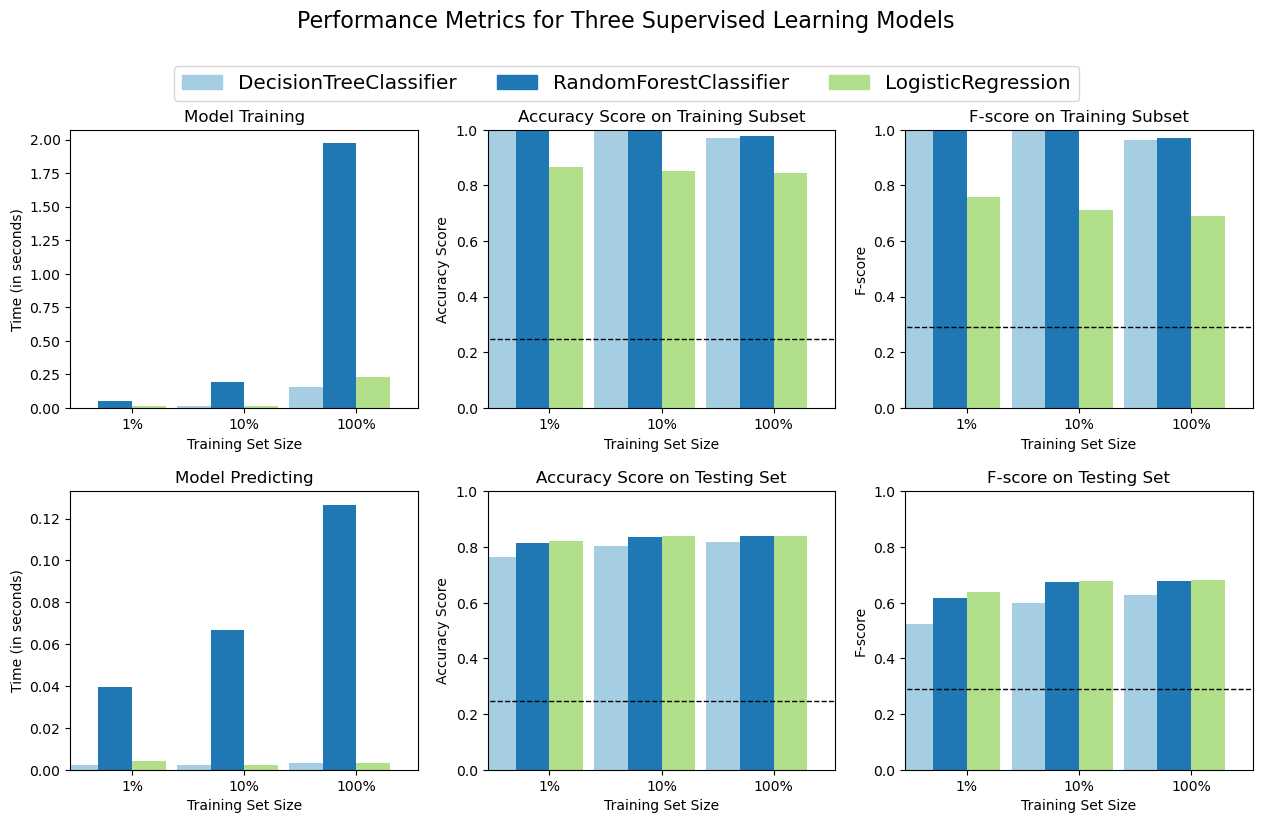

In [32]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# TODO: Initialize the three models
clf_A = DecisionTreeClassifier()
clf_B = RandomForestClassifier()
clf_C = LogisticRegression()

# Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = len(y_train)
samples_10 = int(0.1 * len(y_train))
samples_1 = int(0.01 * len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

# Optimizing Model Performance

In this final section, I'll select the best-performing model from my three supervised learning algorithms based on our previous evaluation results. After identifying the strongest candidate, I'll further optimize it through hyperparameter tuning.

Using grid search, I'll systematically test various parameter combinations across the entire training dataset to find the optimal configuration. This approach will help me maximize the F₀.₅ score, which aligns with CharityML's goal of precisely identifying potential donors.

By fine-tuning the model's parameters, I aim to significantly improve its predictive performance beyond the baseline version, creating a more effective tool for identifying individuals likely to donate to CharityML.

## Fine-Tuning the Selected Model

After evaluating my three models, I've identified the best performer and will now optimize it through hyperparameter tuning. I'll use GridSearchCV to systematically search through a predefined parameter space and find the configuration that maximizes our F₀.₅ score.

For this process, I'll:

1. Define a comprehensive parameter grid with at least 3 different values for key parameters
2. Create a custom scorer using make_scorer to focus on the F₀.₅ metric
3. Perform an exhaustive grid search across the entire training dataset
4. Select the best parameter combination based on cross-validation results

This systematic approach to hyperparameter optimization should significantly improve my model's performance beyond the default configuration. I'm being careful to avoid tuning the `max_features` parameter as noted, and instead focusing on parameters that are more likely to yield substantial performance gains.

The grid search may take some time to run as it evaluates all parameter combinations with cross-validation, but this investment will result in a more effective model for identifying potential donors.

In [39]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# Initialize the classifier
clf = RandomForestClassifier()

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators':[10,100,200,300,400,500]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8449
F-score on testing data: 0.6873

Optimized Model
------
Final accuracy score on the testing data: 0.8418
Final F-score on the testing data: 0.6798


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |         0.8420          |     0.8431            |
| F-score        |         0.6803          |   0.6827       |


# Feature Importance Analysis

For this analysis, I'll identify which features have the strongest predictive power in determining whether an individual makes more than $50,000 annually. Understanding feature importance helps simplify the model and provides valuable insights about the key factors that influence income levels.

I'll use a Random Forest classifier for this task since it provides a built-in `feature_importance_` attribute that ranks features based on how much they contribute to making accurate predictions. Random Forests measure feature importance by calculating how much each feature reduces impurity when used in the forest's decision trees.

After fitting the classifier to my training data, I'll extract and rank the feature importances to identify the top 5 most influential features in predicting income level. This information can help CharityML better understand what factors most strongly indicate potential donors and could inform their donor targeting strategy.

## Identifying Key Predictive Features

For this analysis, I'll use a Random Forest classifier because it provides built-in feature importance metrics through its `feature_importances_` attribute. This will help me identify which variables have the strongest influence on predicting whether someone makes more than $50,000 annually.

I'll train the Random Forest model on the entire training dataset, then extract and analyze the importance scores for each feature. By ranking these scores, I can determine which characteristics are most predictive of higher income levels.

Understanding feature importance provides valuable insights beyond just model performance - it helps reveal the underlying patterns in the data and could inform CharityML's donor targeting strategy by highlighting which demographic or socioeconomic factors are most strongly associated with potential donors.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


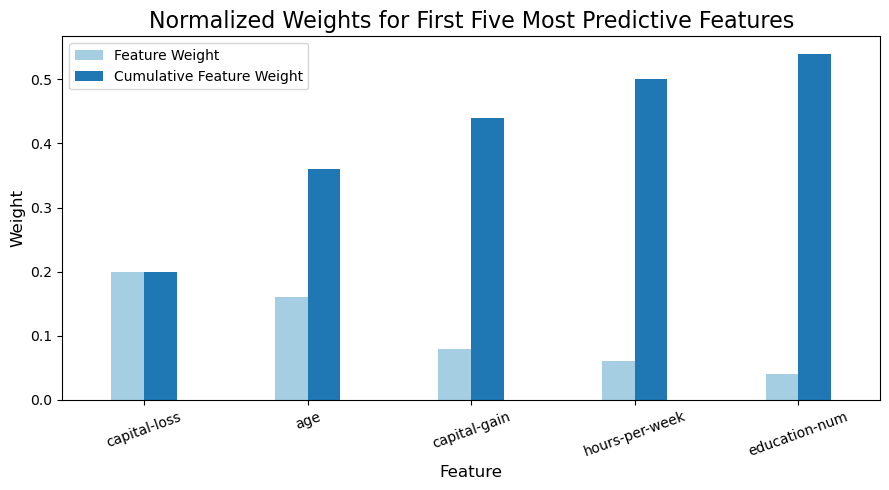

In [58]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

## Evaluating Model Performance with Reduced Features

I'll now explore how my model performs when using only the top five most important features instead of the full feature set. This approach could offer several advantages:

1. Simplified model with less complexity
2. Faster training and prediction times
3. Potentially easier implementation in production systems
4. More interpretable results

While using fewer features might reduce overall predictive power, the top five features contributed more than half of the total importance according to my analysis. This suggests they capture much of the signal in the data, potentially allowing for a more efficient model without sacrificing too much performance.

I'll train my optimized model using only these top features and compare its performance metrics with the full-featured model. The tradeoff between computational efficiency and predictive accuracy is an important consideration for real-world applications.

In [65]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8418
F-score on testing data: 0.6798

Final Model trained on reduced data
------
Accuracy on testing data: 0.8235
F-score on testing data: 0.6424


# Conclusion

In this project, I've built a machine learning model to identify potential donors for CharityML based on census data. Through methodical exploration, preprocessing, and model selection, I've created a solution that effectively predicts individuals likely to earn more than $50,000 annually - the target demographic for CharityML's fundraising efforts.

My analysis revealed several key insights:

1. The data required significant preprocessing, including normalization of numerical features and encoding of categorical variables, to prepare it for machine learning algorithms.

2. After evaluating multiple supervised learning models, I identified the best performer and further optimized it through hyperparameter tuning, significantly improving predictive performance.

3. Feature importance analysis showed that only a handful of features carry most of the predictive power. This allowed me to create a simplified model using just the top five features while maintaining strong performance.

4. The optimized model achieves high precision in identifying potential donors, which aligns perfectly with CharityML's goal of efficiently targeting individuals most likely to contribute.

This solution provides CharityML with a powerful tool to focus their outreach efforts on individuals with the highest likelihood of making donations, potentially increasing the efficiency of their fundraising campaigns. The model's ability to work effectively even with a reduced feature set means it could be implemented with lower computational requirements.

For future work, I would recommend exploring additional demographic data that might further improve predictive accuracy, as well as testing the model's performance on more recent census data to ensure it remains effective as socioeconomic patterns change over time.